In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

datadir = '../../data/'

In [2]:
charge_file = 'charges_PRIVATE_AUTO_base_dev_with_ldv_logic_2021_20230528.parquet'
charges = pd.read_parquet(datadir + charge_file)

load_file = 'loads_PRIVATE_AUTO_base_dev_with_ldv_logic_2021_20230528.parquet'
loads = pd.read_parquet(datadir + load_file)

In [3]:

reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

In [4]:
trips = pd.read_parquet(datadir + 'wa_pop_and_trips_sorted.parquet')

In [5]:
trips.drop(columns=['charge_type'])

,activity_id,person_id,mode,travel_purpose,previous_activity_type,start_time,end_time,distance_miles,vehicle_type,origin_bgrp,...,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,18336634547462657450,10000002909730821040,PRIVATE_AUTO,SOCIAL,HOME,0 days 08:20:42,0 days 08:39:00,2.897196,nan,530250111002,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
1,1694659094182985471,10000002909730821040,PRIVATE_AUTO,HOME,SOCIAL,0 days 09:12:45,0 days 09:19:56,2.867602,nan,530250111003,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
2,7721623352602932778,10000002909730821040,ON_DEMAND_AUTO,SHOP,HOME,0 days 09:30:08,0 days 09:49:04,8.929170,nan,530250111002,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
3,3697919619727259534,10000002909730821040,CARPOOL,SHOP,SHOP,0 days 09:54:21,0 days 09:57:14,0.996870,nan,530250109022,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
4,9977271661694103189,10000002909730821040,WALKING,SHOP,SHOP,0 days 10:23:28,0 days 10:25:01,0.080298,nan,530250111001,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176294,17390194002376271909,129762667123447258,PRIVATE_AUTO,SHOP,HOME,0 days 18:08:13,0 days 18:15:40,3.283053,nan,530330303102,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home
176295,884521432970543080,129762667123447258,PRIVATE_AUTO,SHOP,SHOP,0 days 18:22:16,0 days 18:25:16,0.749009,nan,530330303141,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home
176296,7536433276779622397,129762667123447258,PRIVATE_AUTO,HOME,SHOP,0 days 18:48:28,0 days 18:56:31,3.582652,nan,530330300062,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home


In [6]:
charges = charges[['person_id', 'charge_id', 'charge_type', 'activity_id', 'charger_power_kW']]
loads = loads[['charge_id', 'load_kW', 'window_start_time','window_end_time']]
reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

In [7]:
loadscharges = loads.merge(charges, on='charge_id', how='left')

In [8]:
loadscharges

,charge_id,load_kW,window_start_time,window_end_time,hour,person_id,charge_type,activity_id,charger_power_kW
0,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 00:00:00,0 days 01:00:00,1,13033034909424887242,public,14321003733064875798,19.0
1,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 01:00:00,0 days 02:00:00,2,13033034909424887242,public,14321003733064875798,19.0
2,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 02:00:00,0 days 03:00:00,3,13033034909424887242,public,14321003733064875798,19.0
3,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 03:00:00,0 days 04:00:00,4,13033034909424887242,public,14321003733064875798,19.0
4,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 04:00:00,0 days 05:00:00,5,13033034909424887242,public,14321003733064875798,19.0
...,...,...,...,...,...,...,...,...,...
9427003,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 19:00:00,0 days 20:00:00,20,9287904891057512086,single_family_home,16727905968817968301,7.2
9427004,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 20:00:00,0 days 21:00:00,21,9287904891057512086,single_family_home,16727905968817968301,7.2
9427005,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 21:00:00,0 days 22:00:00,22,9287904891057512086,single_family_home,16727905968817968301,7.2
9427006,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 22:00:00,0 days 23:00:00,23,9287904891057512086,single_family_home,16727905968817968301,7.2


In [9]:
all = loadscharges.merge(trips, on='activity_id', how='left')

In [10]:
all.drop(columns=['person_id_y', 'charge_type_y'], inplace=True)

In [11]:
all.rename(columns={'person_id_x': 'person_id', 'charge_type_x': 'charge_type'}, inplace=True)

In [12]:
df = all[all["destination_bgrp"].str.contains('53063')].copy()
df['location'] = df.charge_type.copy()

In [13]:
df_sub = df.groupby(by=['weekday', 'location', 'hour']).sum().reset_index()
#temp = df_sub.loc[(df_sub.weekday=='thursday') &
#                    (df_sub.location=='single_family_home')].copy().sort_values(by='hour')

In [14]:
df_sub

,weekday,location,hour,charge_id,load_kW,window_start_time,window_end_time,person_id,charge_type,activity_id,...,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh
0,saturday,civic_institutional,0,14489635478452682111_base_dev_with_ldv_logic_2...,0.000000,34 days 12:00:00,36 days 00:00:00,1299977761331877118413410432869980295138141858...,civic_institutionalcivic_institutionalcivic_in...,1448963547845268211118031904977994906320171623...,...,mobilesingle_familysingle_familysingle_familym...,corecorecorecorecorecorecorecorecorecorecoreco...,englishenglishenglishenglishenglishenglishspan...,1715.493780,-4.235827e+03,1666.804030,-4119.914885,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
1,saturday,civic_institutional,1,14489635478452682111_base_dev_with_ldv_logic_2...,0.000000,0 days 00:00:00,1 days 12:00:00,1299977761331877118413410432869980295138141858...,civic_institutionalcivic_institutionalcivic_in...,1448963547845268211118031904977994906320171623...,...,mobilesingle_familysingle_familysingle_familym...,corecorecorecorecorecorecorecorecorecorecoreco...,englishenglishenglishenglishenglishenglishspan...,1715.493780,-4.235827e+03,1666.804030,-4119.914885,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
2,saturday,civic_institutional,2,14489635478452682111_base_dev_with_ldv_logic_2...,0.000000,1 days 12:00:00,3 days 00:00:00,1299977761331877118413410432869980295138141858...,civic_institutionalcivic_institutionalcivic_in...,1448963547845268211118031904977994906320171623...,...,mobilesingle_familysingle_familysingle_familym...,corecorecorecorecorecorecorecorecorecorecoreco...,englishenglishenglishenglishenglishenglishspan...,1715.493780,-4.235827e+03,1666.804030,-4119.914885,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
3,saturday,civic_institutional,3,14489635478452682111_base_dev_with_ldv_logic_2...,0.000000,3 days 00:00:00,4 days 12:00:00,1299977761331877118413410432869980295138141858...,civic_institutionalcivic_institutionalcivic_in...,1448963547845268211118031904977994906320171623...,...,mobilesingle_familysingle_familysingle_familym...,corecorecorecorecorecorecorecorecorecorecoreco...,englishenglishenglishenglishenglishenglishspan...,1715.493780,-4.235827e+03,1666.804030,-4119.914885,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
4,saturday,civic_institutional,4,14489635478452682111_base_dev_with_ldv_logic_2...,0.000000,4 days 12:00:00,6 days 00:00:00,1299977761331877118413410432869980295138141858...,civic_institutionalcivic_institutionalcivic_in...,1448963547845268211118031904977994906320171623...,...,mobilesingle_familysingle_familysingle_familym...,corecorecorecorecorecorecorecorecorecorecoreco...,englishenglishenglishenglishenglishenglishspan...,1715.493780,-4.235827e+03,1666.804030,-4119.914885,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,thursday,single_family_home,19,14931656298745566511_base_dev_with_ldv_logic_2...,6587.009028,7954 days 12:00:00,8396 days 10:00:00,1694547813085250654517952595534964746087108168...,single_family_homesingle_family_homesingle_fam...,1493165629874556651115885784540958758601100171...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecoreco...,spanishenglishenglishenglishenglishenglishasia...,505347.575857,-1.248698e+06,281905.356704,-696563.093404,49210.537392,-121558.988707,worked_in_personunder_16_or_notinlfunder_16_or...
284,thursday,single_family_home,20,14931656298745566511_base_dev_with_ldv_logic_2...,6187.413140,8396 days 10:00:00,8838 days 08:00:00,1694547813085250654517952595534964746087108168...,single_family_homesingle_family_homesingle_fam...,1493165629874556651115885784540958758601100171...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecoreco...,spanisheng

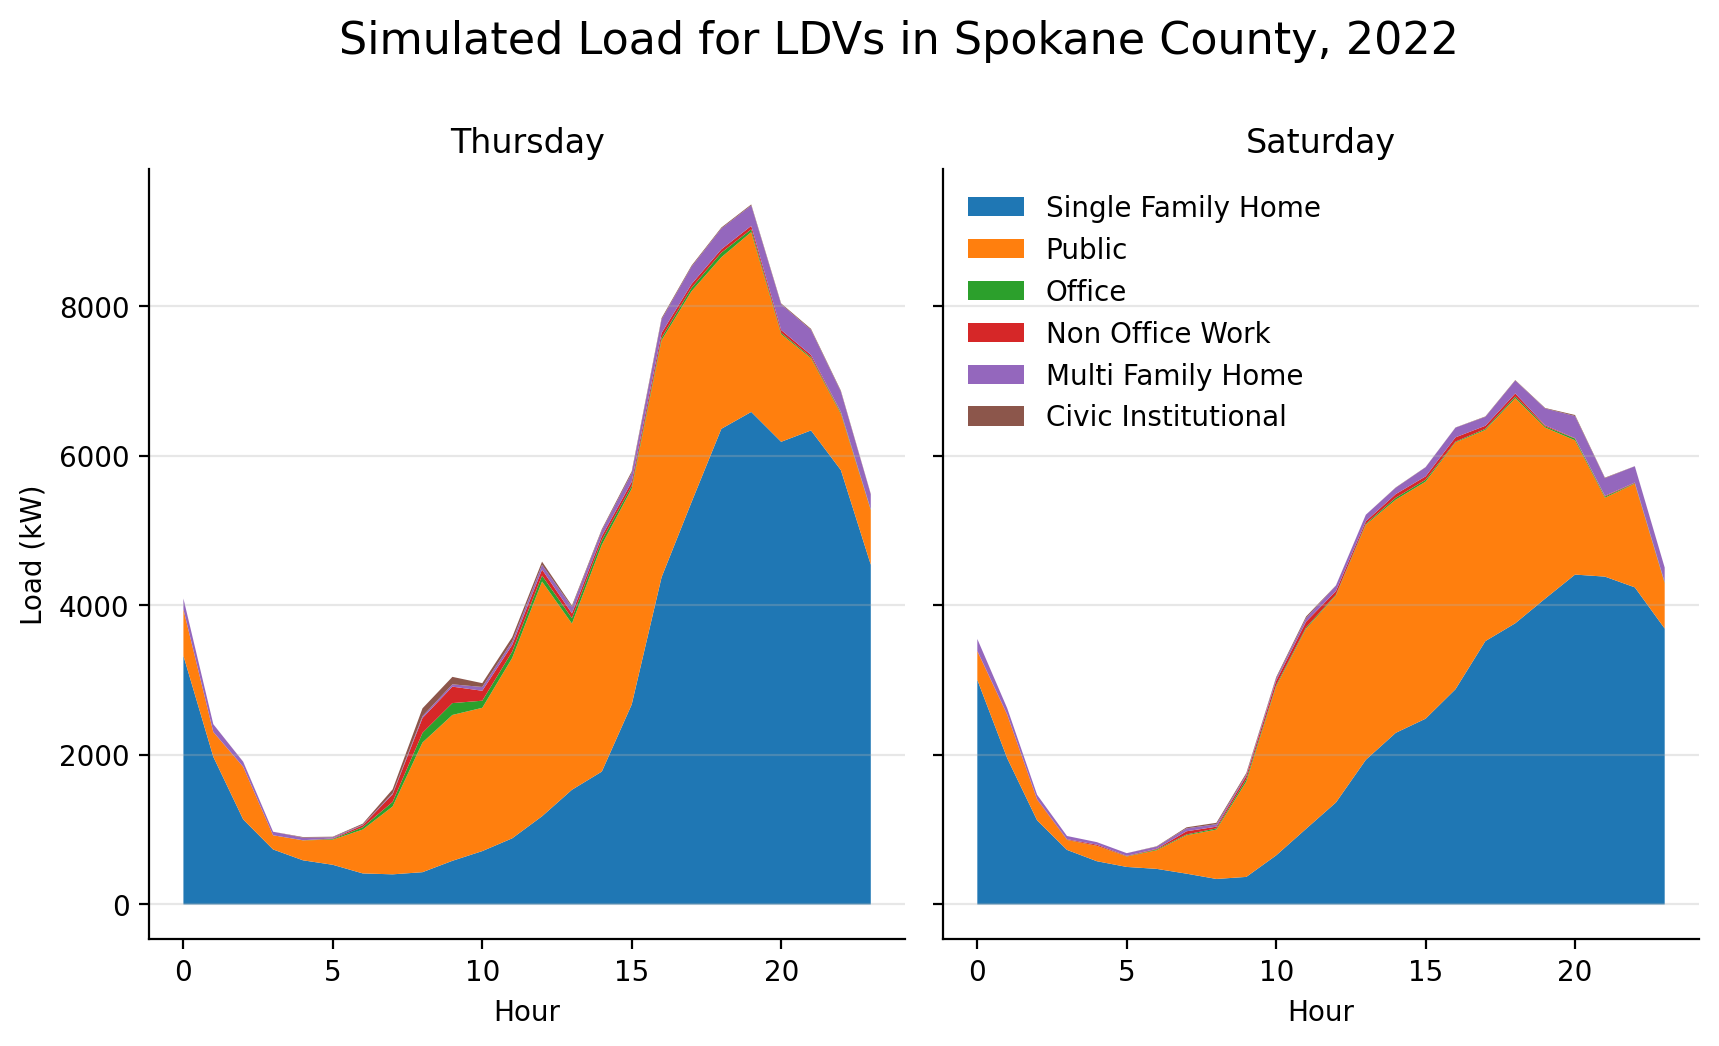

In [15]:
def plot_simulated_load(df_sub, fig_name):
    fig, axes = plt.subplots(ncols=2, figsize=(10,5), sharey=True)
    for ax, day in zip(axes, ['thursday', 'saturday']):
        locations = df_sub.location.unique().copy()[::-1]
        max_load = 0
        base = [0]*len(set(df_sub.hour))
        for idx, loc in enumerate(locations):
            temp = df_sub.loc[(df_sub.weekday==day) & (df_sub.location==loc)].copy().sort_values(by='hour')
            load = list(np.array(base) + temp.load_kW)
            ax.grid(axis='y', which='major', alpha=0.3)
            ax.fill_between(x=list(temp.hour)+list(temp.hour)[::-1],
                        y1=load+base[::-1], 
                        label=locations[idx].replace('_',' ').title(),
                        alpha=1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            base = load
            max_temp = np.max(base)
            max_load = np.max([max_temp, max_load])
        # ax.title(day.title())

    if day == 'saturday':
        plt.legend(loc='upper left', frameon=False)
    axes[0].set_title('Thursday')
    axes[1].set_title('Saturday')
    axes[0].set_ylabel('Load (kW)')
    axes[0].set_xlabel('Hour')
    axes[1].set_xlabel('Hour')

    fig.suptitle('Simulated Load for LDVs in Spokane County, 2022', 
                fontsize=16,
                y=1.03)
    plt.subplots_adjust(wspace=0.05)
    plt.savefig('../visualizations/simulated_load_LDV_spokane_2022.png', dpi=300, bbox_inches='tight')
    plt.show()
    return fig, axes

fig, axes = plot_simulated_load(df_sub, 'simulated_load_LDV_spokane_2022.png')


### sanity check: how many cars charging during peak?

In [16]:
df_sub = df.groupby(by=['weekday', 'location', 'hour']).sum().reset_index()

In [17]:
df_thu = df.loc[(df.weekday=='thursday')].copy()

In [18]:
df_thu[(df_thu['hour'] == 17) & (df_thu['load_kW'] > 0)]['person_id'].unique().shape

(2335,)

In [19]:
len(df_thu), len(df_thu['person_id'].unique())

(396552, 15662)

In [20]:
df_thu[(df_thu['hour'] == 17) & (df_thu['load_kW'] > 0)]['load_kW'].sum()

8542.80868476782

In [22]:
stop_time = 16.50
time_window = 1
start_index = int(np.floor(stop_time/time_window)) 
proportion_of_start_window = (
            time_window-stop_time % time_window)/time_window

TypeError: unsupported operand type(s) for /: 'Timestamp' and 'Timedelta'

In [ ]:
        charge_demand=df_sub.charge_energy_used_kWh.iloc[i],
        stop_time=trips_temp.end_time.iloc[i],
        stop_duration=trips_temp.stop_duration.iloc[i],
        time_window=pd.Timedelta('1 hour'),
        charge_power=trips_temp.charger_power_kW.iloc[i]